# Predição de Valor de Passagem Aérea

## Objetivo

Aplicação de machine learning para predição do valor de passagem aérea comprada pela administração pública federal, com dados do Sistema de Concessão de Diárias e Passagens (SCDP).

## Coleta de Dados

In [1]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Leitura do arquivo CSV com os dados das passagens aéreas de 2019
trechos = pd.read_csv("passagens_trechos_2019.csv", 
                      sep=';', quotechar='"', decimal=',', thousands='.',
                      parse_dates=['data_solicitacao_viagem', 'data_inicio_viagem', 'data_fim_viagem', 
                                   'data_partida', 'data_chegada', 'hora_partida', 'hora_chegada'], 
                      infer_datetime_format=True)
trechos.shape

(417382, 20)

In [3]:
pd.set_option("display.max_columns", 50)
trechos.head()

,id,numero_da_pcdp,tipo_compra,data_solicitacao_viagem,data_inicio_viagem,data_fim_viagem,data_partida,data_chegada,hora_partida,hora_chegada,pais_origem,uf_origem,cidade_origem,pais_destino,uf_destino,cidade_destino,motivo_viagem,viagem_urgente_sn,viagem_internacional_sn,vl_tarifa
0,15669084,000088/19,Agência de viagem,2019-01-14,2019-02-09,2019-02-19,2019-02-09,2019-02-09,2020-10-18 12:02:00,2020-10-18 14:29:00,Brasil,AM,Manaus,Brasil,AM,Eirunepé,Atividades PARFOR,1,0,1239.90
1,15669084,000088/19,Agência de viagem,2019-01-14,2019-02-09,2019-02-19,2019-02-19,2019-02-19,2020-10-18 15:19:00,2020-10-18 19:46:00,Brasil,AM,Eirunepé,Brasil,AM,Manaus,Atividades PARFOR,1,0,819.90
2,15705007,000073/19,Agência de viagem,2019-02-04,2019-02-19,2019-02-21,2019-02-21,2019-02-21,2020-10-18 13:35:00,2020-10-18 18:00:00,Brasil,SE,Aracaju,Brasil,ES,Vitória,Nacional - Convocação,0,0,674.90
3,15743248,000107/19,Agência de viagem,2019-01-28,2019-01-10,2019-02-28,2019-01-12,2019-01-12,2020-10-18 01:30:00,2020-10-18 02:50:00,Turquia,NaN,Istambul,Egito,NaN,Cairo,Internacional - A Serviço,1,1,1849.37
4,15754403,000024/19,Agência de viagem,2019-01-25,2019-02-05,2019-02-07,2019-02-05,2019-02-05,2020-10-18 21:25:00,2020-10-18 23:05:00,Brasil,SP,Campinas,Brasil,DF,Brasília,Nacional - A Serviço,0,0,536.90


In [4]:
trechos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417382 entries, 0 to 417381
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       417382 non-null  int64         
 1   numero_da_pcdp           417382 non-null  object        
 2   tipo_compra              417382 non-null  object        
 3   data_solicitacao_viagem  417382 non-null  datetime64[ns]
 4   data_inicio_viagem       417382 non-null  datetime64[ns]
 5   data_fim_viagem          417382 non-null  datetime64[ns]
 6   data_partida             417382 non-null  datetime64[ns]
 7   data_chegada             417382 non-null  datetime64[ns]
 8   hora_partida             417382 non-null  datetime64[ns]
 9   hora_chegada             417382 non-null  datetime64[ns]
 10  pais_origem              417382 non-null  object        
 11  uf_origem                407465 non-null  object        
 12  cidade_origem   

## Análise Exploratória dos Dados

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### Dados nulos

In [6]:
trechos.isnull().sum()
# Provavelmente as UFs não preenchidas se referem a cidades do exterior

id                            0
numero_da_pcdp                0
tipo_compra                   0
data_solicitacao_viagem       0
data_inicio_viagem            0
data_fim_viagem               0
data_partida                  0
data_chegada                  0
hora_partida                  0
hora_chegada                  0
pais_origem                   0
uf_origem                  9917
cidade_origem                 0
pais_destino                  0
uf_destino                 9342
cidade_destino                0
motivo_viagem                 0
viagem_urgente_sn             0
viagem_internacional_sn       0
vl_tarifa                     0
dtype: int64

In [7]:
# Confirmando: os trechos que não possuem UF informada referem-se a viagens internacionais
trechos[(trechos.pais_origem == 'Brasil') & (trechos.pais_destino == 'Brasil')].isnull().sum().any()

False

#### Histogramas

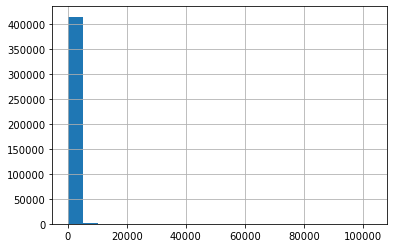

In [8]:
# Histogramas das variáveis numéricas não id e não binárias
trechos['vl_tarifa'].hist(bins=20)
plt.show()

#### Outliers

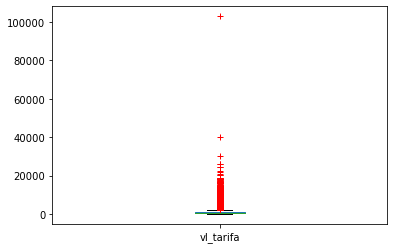

In [9]:
# Verifica a existência de outliers no valor da passagem
trechos[['vl_tarifa']].plot.box(sym='r+')

In [10]:
# Verifica estatísticas do valor da passagem
trechos.vl_tarifa.describe()

count    417382.000000
mean        920.758124
std         812.795317
min           0.000000
25%         502.900000
50%         783.660000
75%        1134.900000
max      103011.160000
Name: vl_tarifa, dtype: float64

In [11]:
# Outliers (passagens com valor 0 ou maior do que R$ 50.000,00)
trechos[(trechos.vl_tarifa == 0.) | (trechos.vl_tarifa > 50000.)].shape
# OBS: passagens com valores baixos provavelmente são "ida e volta", onde valor maior foi informado em um só trecho

(2727, 20)

In [12]:
# Localiza alguns outliers
trechos[trechos.vl_tarifa > 50000.]
# É uma viagem internacional

,id,numero_da_pcdp,tipo_compra,data_solicitacao_viagem,data_inicio_viagem,data_fim_viagem,data_partida,data_chegada,hora_partida,hora_chegada,pais_origem,uf_origem,cidade_origem,pais_destino,uf_destino,cidade_destino,motivo_viagem,viagem_urgente_sn,viagem_internacional_sn,vl_tarifa
178781,16154465,000107/19-1C,Agência de viagem,2019-05-29,2019-06-09,2019-06-16,2019-06-15,2019-06-16,2020-10-18 22:25:00,2020-10-18 11:45:00,Reino Unido,NaN,Londres,Brasil,DF,Brasília,Internacional - A Serviço,1,1,103011.16


## Tratamento dos Dados

#### Trata dados nulos

In [13]:
# Remove linhas com UF's nulas (viagens internacionais). O escopo é somente viagens nacionais.
trechos.dropna(inplace=True)
trechos.isnull().sum().any()

False

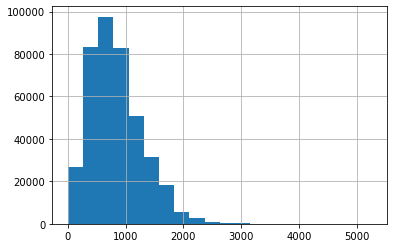

In [14]:
# Novo histogramas dos valores das passagens
trechos['vl_tarifa'].hist(bins=20)
plt.show()

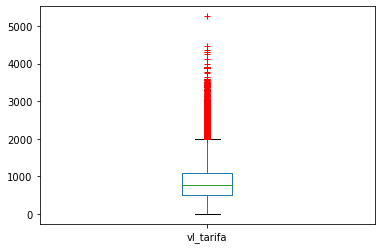

In [15]:
# Novo box plot dos valores da passagens
trechos[['vl_tarifa']].plot.box(sym='r+')

In [16]:
# Verifica estatísticas do valor da passagem
trechos.vl_tarifa.describe()

count    400332.000000
mean        832.467089
std         445.845250
min           0.000000
25%         498.547500
50%         768.510000
75%        1093.197500
max        5257.310000
Name: vl_tarifa, dtype: float64

In [17]:
# Quantas passagens com valor menor do que R$ 50,00 ?
trechos[(trechos.vl_tarifa < 50.)].shape

(1732, 20)

In [18]:
# Obtém os id's dos trechos cujos valor da passagem é menor do que R$ 50,00
# Passagens com valores baixos provavelmente são "ida e volta", onde o valor maior foi informado em um só trecho
ids_outliers = trechos[(trechos.vl_tarifa < 50.)].id
ids_outliers.shape

(1732,)

#### Remove outliers em valor da passagem

In [19]:
# Remove linhas com os id's dos outliers
cond = trechos['id'].isin(ids_outliers)
trechos.drop(trechos[cond].index, inplace=True)
trechos.shape

(396835, 20)

In [20]:
# Verifica estatísticas do valor da passagem
trechos.vl_tarifa.describe()

count    396835.000000
mean        833.785474
std         440.325896
min          52.900000
25%         500.420000
50%         769.110000
75%        1092.870000
max        4301.120000
Name: vl_tarifa, dtype: float64

In [21]:
# Passagens com valor do que R$ 4.000,00
trechos[(trechos.vl_tarifa > 4000.)]
# Apesar do valor alto, não parece ser inconsistência nem viagem "ida e volta" porque é um trajeto longo (CE->RS)

,id,numero_da_pcdp,tipo_compra,data_solicitacao_viagem,data_inicio_viagem,data_fim_viagem,data_partida,data_chegada,hora_partida,hora_chegada,pais_origem,uf_origem,cidade_origem,pais_destino,uf_destino,cidade_destino,motivo_viagem,viagem_urgente_sn,viagem_internacional_sn,vl_tarifa
107481,16013314,000205/19,Agência de viagem,2019-04-16,2019-04-22,2019-04-25,2019-04-22,2019-04-22,2020-10-18 02:30:00,2020-10-18 17:05:00,Brasil,CE,Juazeiro do Norte,Brasil,RS,Santa Maria,Nacional - Treinamento,1,0,4301.12


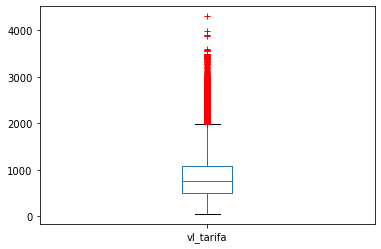

In [22]:
# Novo box plot dos valores da passagens
trechos[['vl_tarifa']].plot.box(sym='r+')

#### Dados sem relevância para a variável resposta

In [23]:
# Como o motivo da viagem não afeta o preço da passagem, esta variável pode ser removida
trechos.drop(['motivo_viagem'], axis=1, inplace=True)

## Feature Extraction

#### Tipos de Compra

In [24]:
# Transforma a variável "tipo de compra" em numérica
trechos.tipo_compra.replace(['Compra Direta', 'Agência de viagem', 'PCDP grupo'], [1, 2, 3], inplace=True)
trechos.tipo_compra.value_counts()

2    297308
1     99527
Name: tipo_compra, dtype: int64

#### Cidades

In [25]:
# Concatena nome da cidade com nome da UF para diferenciar as homônimas
trechos['origem'] = (trechos.cidade_origem + '-' + trechos.uf_origem).str.upper()
trechos['destino'] = (trechos.cidade_destino + '-' + trechos.uf_destino).str.upper()
# trechos.origem.value_counts().count()
trechos.origem.nunique()

305

In [26]:
# Lê informações de latitude/longitude das cidades brasileiras
estados = pd.read_csv("estados.csv", usecols=['codigo_uf', 'uf', 'nome']).rename(columns={'nome': 'nome_uf'})
municipios = pd.read_csv("municipios.csv").rename(columns={'nome': 'nome_municipio'})

cidades = pd.merge(municipios, estados, on='codigo_uf')
cidades['cidade_uf'] = (cidades.nome_municipio + '-' + cidades.uf).str.upper()
cidades = cidades[['cidade_uf', 'latitude', 'longitude']]
cidades.head()

,cidade_uf,latitude,longitude
0,ABADIA DE GOIÁS-GO,-16.7573,-49.4412
1,ABADIÂNIA-GO,-16.1970,-48.7057
2,ACREÚNA-GO,-17.3960,-50.3749
3,ADELÂNDIA-GO,-16.4127,-50.1657
4,ÁGUA FRIA DE GOIÁS-GO,-14.9778,-47.7823


In [27]:
# Preenche latitude/longitude das cidades de origem
trechos = pd.merge(trechos, cidades, left_on='origem', right_on='cidade_uf')
trechos = trechos.rename(columns={'latitude': 'latitude_origem', 'longitude': 'longitude_origem'})
trechos.drop(['cidade_uf'], axis=1, inplace=True)

In [28]:
# Preenche latitude/longitude das cidades de destino
trechos = pd.merge(trechos, cidades, left_on='destino', right_on='cidade_uf')
trechos = trechos.rename(columns={'latitude': 'latitude_destino', 'longitude': 'longitude_destino'})
trechos.drop(['cidade_uf'], axis=1, inplace=True)

In [29]:
# Cria a função que calcula a distância de Haversine (considera a curvatura da Terra)
def haversine_vectorize(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    newlon = lon2 - lon1
    newlat = lat2 - lat1
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
    dist = 2 * np.arcsin(np.sqrt(haver_formula))
    km = 6367 * dist # 6367 para distância in KM, para milhas usar 3958
    return km

In [30]:
# Calcula a distância entre cidades origem e destino usando Haversine
trechos['distancia'] = haversine_vectorize(trechos['longitude_origem'], 
                                           trechos['latitude_origem'], 
                                           trechos['longitude_destino'], 
                                           trechos['latitude_destino'])

In [31]:
# Exemplos de distâncias
trechos[['origem', 'destino', 'distancia']].drop_duplicates().head()

,origem,destino,distancia
0,MANAUS-AM,EIRUNEPÉ-AM,1158.612564
90,TEFÉ-AM,EIRUNEPÉ-AM,676.818455
99,ENVIRA-AM,EIRUNEPÉ-AM,88.619410
103,MANAUS-AM,TABATINGA-AM,1106.799970
879,CAMPINAS-SP,TABATINGA-AM,3215.207809


In [32]:
# Cria variável distância por intervalos (bins) das distâncias contínuas
trechos['distancia_bin'] = pd.cut(trechos.distancia, bins=5).astype('category').cat.codes
trechos.distancia_bin.value_counts()

1    158352
0    146982
2     63399
3     25614
4      2118
Name: distancia_bin, dtype: int64

#### UFs

In [33]:
# Cria variável trajeto com a concatenação da UF origem com a UF destino
trechos['trajeto'] = trechos.uf_origem + '-' + trechos.uf_destino
trechos['trajeto'].value_counts().head()

SP-DF    19652
DF-SP    19559
DF-RJ    16556
RJ-DF    16486
MG-DF     6612
Name: trajeto, dtype: int64

In [34]:
# Quantidade de trajetos distintos
trechos.trajeto.value_counts().count()

720

In [35]:
# Cria variável trajeto_num codificando numericamente a categoria trajeto
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
trajeto_lbl = lbl.fit_transform(trechos['trajeto'])
trechos['trajeto_num'] = trajeto_lbl

#### Datas das viagens

In [36]:
from datetime import datetime, timedelta, date, time

In [37]:
# Cria variável com dias de antecedência entre a data de solicitação da passagem e a data da partida
trechos['antecedencia'] = trechos.data_partida - trechos.data_solicitacao_viagem

# Se houver antecedência negativa, pode ser inconsistência devido às viagens urgentes. Substitui por 0.
trechos.loc[trechos.antecedencia < timedelta(0), 'antecedencia'] = timedelta(0)
trechos.antecedencia.sort_values().value_counts(dropna=False)

13 days     18374
14 days     16733
12 days     16664
16 days     16323
11 days     16290
            ...  
389 days        1
357 days        1
289 days        1
355 days        1
338 days        1
Name: antecedencia, Length: 324, dtype: int64

In [38]:
# Transforma em numérico
trechos.antecedencia = trechos.antecedencia.dt.days

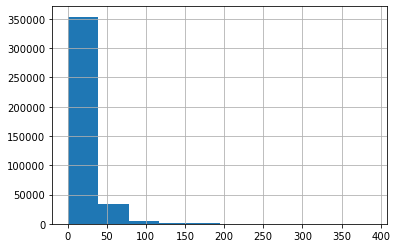

In [39]:
trechos.antecedencia.hist()

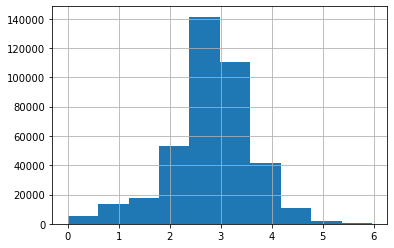

In [40]:
# Cria variável com logaritmo da antecedência, para melhorar a distribuição
trechos['antecede_log'] = np.log(trechos.antecedencia + 1)
trechos['antecede_log'].hist()

In [41]:
# Cria variável do mês de partida da viagem para indicar a sazonalidade
trechos['mes_partida'] = trechos['data_partida'].dt.month
trechos.mes_partida.value_counts().sort_values(ascending=False).head()

11    46165
8     43404
5     38971
10    38927
9     37436
Name: mes_partida, dtype: int64

In [42]:
# Cria variável indicando se viagem ocorreu em mês de férias (janeiro, julho ou dezembro)
trechos['mes_ferias'] = trechos.mes_partida.isin([1, 7, 12]).astype(int)
trechos['mes_ferias'].value_counts()

0    325971
1     70494
Name: mes_ferias, dtype: int64

In [43]:
# Cria variável do dia da semana da partida da viagem (segunda-feira: 0, terça: 1, ... domingo: 6)
trechos['dia_semana'] = trechos['data_partida'].dt.weekday
trechos.dia_semana.value_counts().sort_values(ascending=False).head()

4    68126
6    65080
0    62245
2    60971
3    52519
Name: dia_semana, dtype: int64

In [44]:
# Cria variável indicando se a viagem ocorreu no fim de semana
trechos['fim_semana'] = trechos.dia_semana.isin([5, 6]).astype(int)
trechos['fim_semana'].value_counts()

0    292155
1    104310
Name: fim_semana, dtype: int64

In [45]:
# Cria variável indicando se a viagem ocorreu na segunda ou sexta-feira
trechos['segunda_ou_sexta'] = trechos.dia_semana.isin([0, 4]).astype(int)
trechos['segunda_ou_sexta'].value_counts()

0    266094
1    130371
Name: segunda_ou_sexta, dtype: int64

#### Horas das viagens

In [46]:
# Cria variável indicando se a viagem 
def hour_map(x):
    if time(0,0) <= x <= time(6,0):
        return 1
    else:
        return 2

trechos['turno_viagem'] = trechos['hora_partida'].dt.time.apply(hour_map)
trechos.turno_viagem.value_counts()

2    359878
1     36587
Name: turno_viagem, dtype: int64

In [47]:
trechos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396465 entries, 0 to 396464
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       396465 non-null  int64         
 1   numero_da_pcdp           396465 non-null  object        
 2   tipo_compra              396465 non-null  int64         
 3   data_solicitacao_viagem  396465 non-null  datetime64[ns]
 4   data_inicio_viagem       396465 non-null  datetime64[ns]
 5   data_fim_viagem          396465 non-null  datetime64[ns]
 6   data_partida             396465 non-null  datetime64[ns]
 7   data_chegada             396465 non-null  datetime64[ns]
 8   hora_partida             396465 non-null  datetime64[ns]
 9   hora_chegada             396465 non-null  datetime64[ns]
 10  pais_origem              396465 non-null  object        
 11  uf_origem                396465 non-null  object        
 12  cidade_origem   

## Feature Selection

In [48]:
# Seleciona variáveis numéricas + origem e destino
trechos_sel = trechos.drop(['id', 'numero_da_pcdp', 'data_solicitacao_viagem', 'data_inicio_viagem', 'data_fim_viagem',
                           'data_partida', 'data_chegada', 'hora_partida', 'hora_chegada', 'pais_origem', 'pais_destino',
                           'viagem_internacional_sn'], axis=1)

In [49]:
# Verifica a correlação entre as variáveis e o preço da passagem
corr = trechos_sel.corr()
corr['vl_tarifa'].sort_values(ascending=False)

vl_tarifa            1.000000
viagem_urgente_sn    0.385055
distancia_bin        0.332801
distancia            0.332750
latitude_origem      0.118883
latitude_destino     0.092060
fim_semana           0.055748
tipo_compra          0.038132
dia_semana           0.031035
mes_ferias           0.029167
segunda_ou_sexta     0.017685
mes_partida          0.006787
trajeto_num         -0.033744
longitude_destino   -0.066205
longitude_origem    -0.073060
turno_viagem        -0.104076
antecedencia        -0.247546
antecede_log        -0.382911
Name: vl_tarifa, dtype: float64

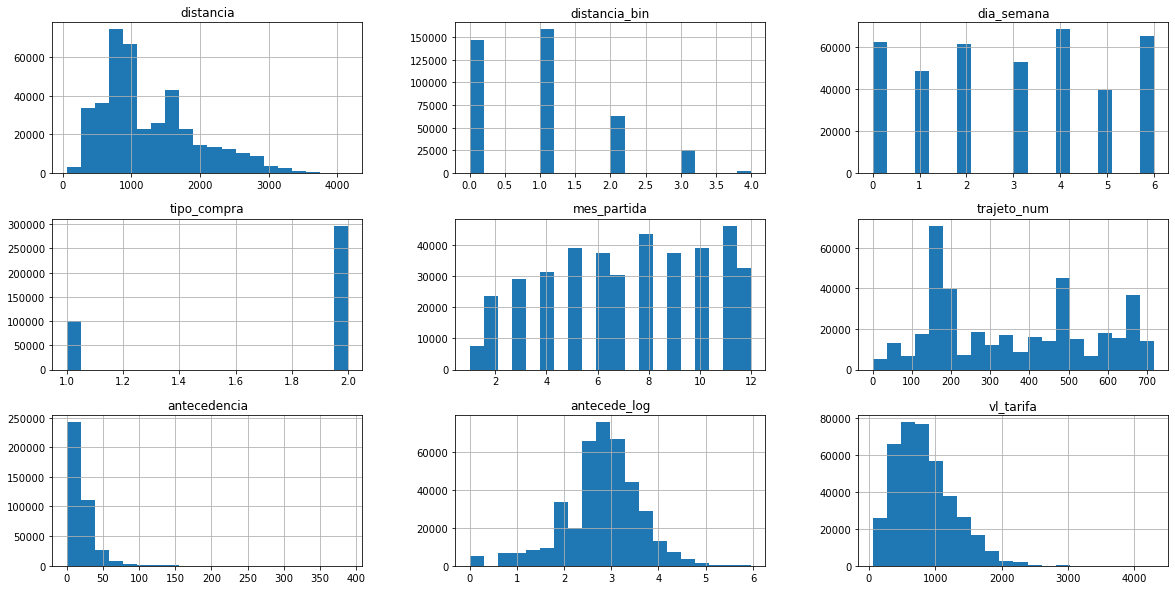

In [50]:
# Histogramas das variáveis numéricas não id e não binárias
cols = ['distancia', 'distancia_bin', 'dia_semana', 'tipo_compra', 'mes_partida', 'trajeto_num',
        'antecedencia', 'antecede_log', 'vl_tarifa']
trechos_sel[cols].hist(bins=20, figsize=(20, 10))
plt.show()

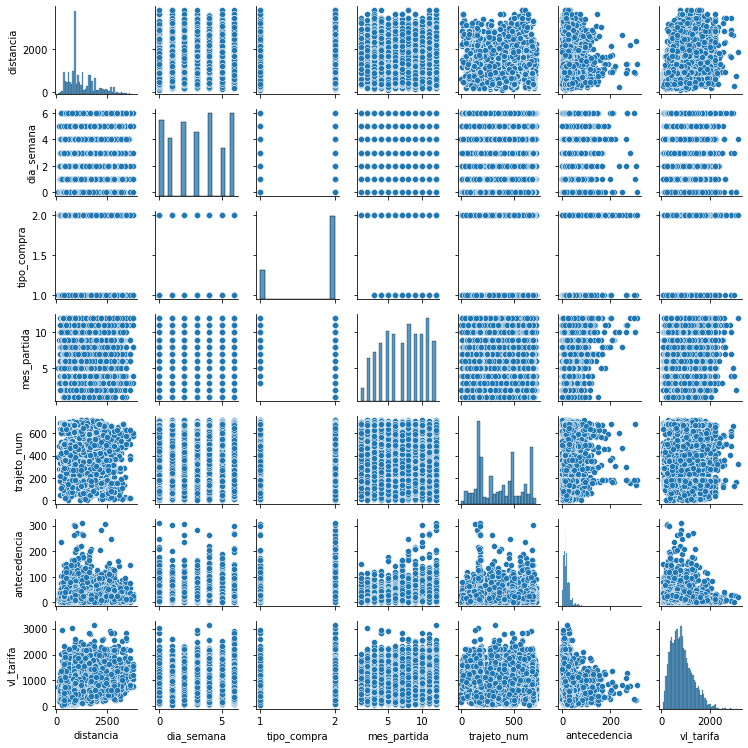

In [51]:
# Matriz de dispersão relacionando pares de variáveis
cols = ['distancia', 'dia_semana', 'tipo_compra', 'mes_partida', 'trajeto_num', 'antecedencia', 'vl_tarifa']
sns.pairplot(trechos_sel[cols].sample(10000), height=1.5)
plt.tight_layout()

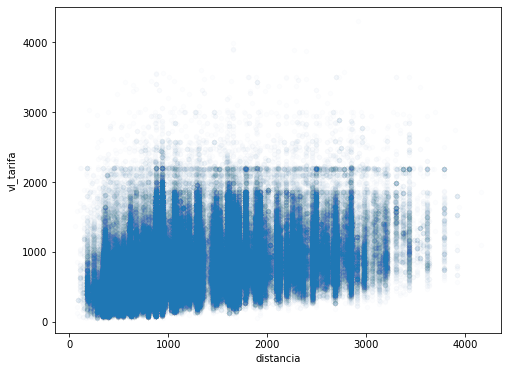

In [52]:
# Matriz de dispersão relacionando distancia com vl_tarifa
trechos_sel.plot(kind='scatter', x='distancia', y='vl_tarifa', alpha=0.01, figsize=(8,6))
plt.show()

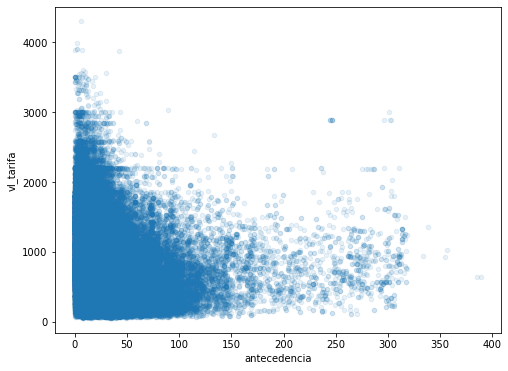

In [53]:
# Matriz de dispersão relacionando antecedencia com vl_tarifa
trechos_sel.plot(kind='scatter', x='antecedencia', y='vl_tarifa', alpha=0.1, figsize=(8,6))
plt.show()

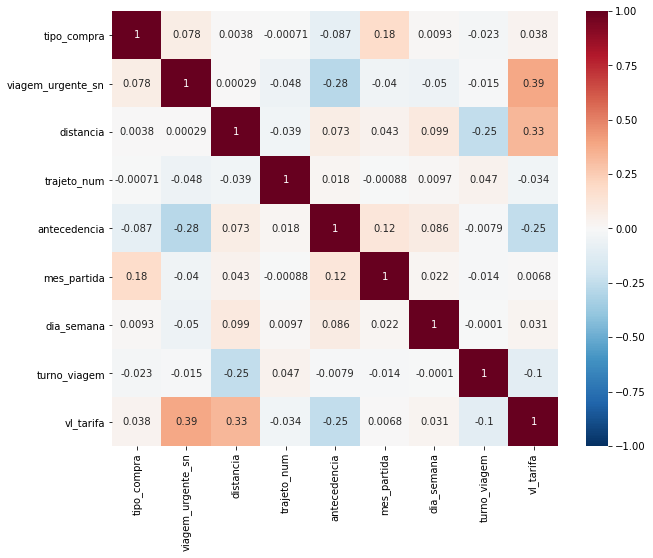

In [54]:
# Mapa de calor com a correlação entre algumas variáveis
cols = ['tipo_compra', 'viagem_urgente_sn', 'distancia', 'trajeto_num', 'antecedencia', 'mes_partida',
       'dia_semana', 'turno_viagem', 'vl_tarifa']
corr = trechos_sel[cols].corr()
fig = plt.figure(figsize=(10,8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            annot=True, cmap="RdBu_r", vmin=-1, vmax=1)

In [55]:
# Variáveis selecionadas
trechos_vars = trechos_sel
trechos_vars.columns

Index(['tipo_compra', 'uf_origem', 'cidade_origem', 'uf_destino',
       'cidade_destino', 'viagem_urgente_sn', 'vl_tarifa', 'origem', 'destino',
       'latitude_origem', 'longitude_origem', 'latitude_destino',
       'longitude_destino', 'distancia', 'distancia_bin', 'trajeto',
       'trajeto_num', 'antecedencia', 'antecede_log', 'mes_partida',
       'mes_ferias', 'dia_semana', 'fim_semana', 'segunda_ou_sexta',
       'turno_viagem'],
      dtype='object')

## Criação dos Modelos

#### Function para métricas

In [56]:
# Métricas R2 Score, MAE e RMSE para avaliação do modelo
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def score_and_error(model, Xtrain, ytrain):
    ypred = model.predict(Xtrain)
    r2 = r2_score(ytrain, ypred)
    mae = mean_absolute_error(ytrain, ypred)
    mse = mean_squared_error(ytrain, ypred)
    print("R^2:", r2, "MAE:", mae, "RMSE:", np.sqrt(mse))

### Feature Selection 1

In [57]:
trechos_prep = trechos_vars.copy()

#### Label Encoding nas cidades origem e destino

In [58]:
# Transformação das origens e destinos em numéricos
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
lbl_num = lbl.fit_transform(trechos_prep['origem'])
trechos_prep.origem = lbl_num
lbl_num = lbl.fit_transform(trechos_prep['destino'])
trechos_prep.destino = lbl_num

In [59]:
# Remove variáveis não numéricas
cols = ['uf_origem', 'cidade_origem', 'uf_destino', 'cidade_destino', 'trajeto']
trechos_prep.drop(cols, axis=1, inplace=True)

#### Random Split

In [60]:
from sklearn.model_selection import train_test_split

X = trechos_prep.drop(columns=['vl_tarifa'])
y = trechos_prep['vl_tarifa']

# Separa conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Model-Based Feature Selection

In [61]:
# Decision Tree Regressor
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor

select = SelectFromModel(DecisionTreeRegressor(), threshold="median")
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

mask = select.get_support()
vars_dtr = X_train.columns[mask]
vars_dtr

X_train.shape: (277525, 19)
X_train_l1.shape: (277525, 10)


Index(['viagem_urgente_sn', 'longitude_origem', 'longitude_destino',
       'distancia', 'distancia_bin', 'trajeto_num', 'antecedencia',
       'antecede_log', 'mes_partida', 'dia_semana'],
      dtype='object')

In [62]:
# Linear Regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression

select = SelectFromModel(LinearRegression(), threshold="median")
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

mask = select.get_support()
vars_lr = X_train.columns[mask]
vars_lr

X_train.shape: (277525, 19)
X_train_l1.shape: (277525, 10)


Index(['tipo_compra', 'viagem_urgente_sn', 'longitude_origem', 'distancia_bin',
       'antecede_log', 'mes_partida', 'mes_ferias', 'fim_semana',
       'segunda_ou_sexta', 'turno_viagem'],
      dtype='object')

#### Decision Tree Regression

In [63]:
X = trechos_prep[vars_dtr]
y = trechos_prep['vl_tarifa']

# Separa conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [64]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor().fit(X_train, y_train)
score_and_error(model_dtr, X_train, y_train)

R^2: 0.9112892699674726 MAE: 56.11507883080431 RMSE: 131.0707939029824


#### Random Forest Regression

In [65]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1).fit(X_train, y_train)
score_and_error(model_rf, X_train, y_train)

R^2: 0.8732297864425392 MAE: 101.22221193867765 RMSE: 156.68465451822402


#### XGBoost

In [66]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(random_state=42, n_jobs=-1).fit(X_train, y_train)
score_and_error(model_xgb, X_train, y_train)

[09:48:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2: 0.4267001471104883 MAE: 250.2858846321757 RMSE: 333.20289688819076


#### Extra Trees

In [67]:
from sklearn.ensemble import ExtraTreesRegressor
model_etr = ExtraTreesRegressor(random_state=42, n_jobs=-1).fit(X_train, y_train)
score_and_error(model_etr, X_train, y_train)

R^2: 0.9112892518117169 MAE: 56.11570322548408 RMSE: 131.07080731561678


#### Linear Regression

In [68]:
X = trechos_prep[vars_lr]
y = trechos_prep['vl_tarifa']

# Separa conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [69]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression().fit(X_train, y_train)
score_and_error(model_lr, X_train, y_train)

R^2: 0.32506324473309967 MAE: 278.7569163220452 RMSE: 361.53420545891817


#### Polynomial Regression

In [70]:
# Transforma em polinômios
from sklearn.preprocessing import PolynomialFeatures
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_train)

from sklearn.linear_model import LinearRegression
model_pr = LinearRegression().fit(X_poly, y_train)
score_and_error(model_pr, X_poly, y_train)

R^2: 0.34761256470706325 MAE: 273.0958109115045 RMSE: 355.44355789780883


#### SGD (Stochastic Gradient Descent) Regression

In [71]:
# Requer padronização dos dados
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_train)

from sklearn.linear_model import SGDRegressor
model_sgdr = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42).fit(X_scaled, y_train.ravel())
score_and_error(model_sgdr, X_scaled, y_train.ravel())

R^2: 0.31776820930538086 MAE: 281.1048171679809 RMSE: 363.4827706338392


#### Gradient Boosting Regression

In [72]:
from sklearn.ensemble import GradientBoostingRegressor
model_gbr = GradientBoostingRegressor(random_state=42).fit(X_train, y_train)
score_and_error(model_gbr, X_train, y_train)

R^2: 0.38398787705727166 MAE: 263.413778211342 RMSE: 345.39216598500076


#### SVM (Support Vector Machine) Regression

In [73]:
# Requer padronização dos dados
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_train)

from sklearn.svm import LinearSVR
model_svmlr = LinearSVR(epsilon=1, random_state=42).fit(X_scaled, y_train)
score_and_error(model_svmlr, X_scaled, y_train)

R^2: 0.309336115959878 MAE: 274.96788013937 RMSE: 365.7221183833131


#### KNN (K-Nearest Neighbors) Regression

In [74]:
# Requer padronização dos dados
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_train)

from sklearn.neighbors import KNeighborsRegressor
model_knnr = KNeighborsRegressor(n_neighbors=3, n_jobs=-1).fit(X_scaled, y_train)
score_and_error(model_knnr, X_scaled, y_train)

R^2: 0.5591331048105419 MAE: 208.70183925772452 RMSE: 292.1942045292219


### Feature Selection 2

In [75]:
trechos_prep = trechos_vars.copy()

####  One Hot encoding (com pandas dummies) nas UFs destino

In [76]:
dummies = pd.get_dummies(trechos_prep[['uf_destino']], prefix=['uf_dest'])

In [77]:
trechos_1hot = pd.concat([trechos_prep, dummies], axis=1)
cols = ['uf_origem', 'cidade_origem', 'origem', 'uf_destino', 
        'cidade_destino', 'destino', 'trajeto']
trechos_prep = trechos_1hot.drop(cols, axis=1)
trechos_prep.columns

Index(['tipo_compra', 'viagem_urgente_sn', 'vl_tarifa', 'latitude_origem',
       'longitude_origem', 'latitude_destino', 'longitude_destino',
       'distancia', 'distancia_bin', 'trajeto_num', 'antecedencia',
       'antecede_log', 'mes_partida', 'mes_ferias', 'dia_semana', 'fim_semana',
       'segunda_ou_sexta', 'turno_viagem', 'uf_dest_AC', 'uf_dest_AL',
       'uf_dest_AM', 'uf_dest_AP', 'uf_dest_BA', 'uf_dest_CE', 'uf_dest_DF',
       'uf_dest_ES', 'uf_dest_GO', 'uf_dest_MA', 'uf_dest_MG', 'uf_dest_MS',
       'uf_dest_MT', 'uf_dest_PA', 'uf_dest_PB', 'uf_dest_PE', 'uf_dest_PI',
       'uf_dest_PR', 'uf_dest_RJ', 'uf_dest_RN', 'uf_dest_RO', 'uf_dest_RR',
       'uf_dest_RS', 'uf_dest_SC', 'uf_dest_SE', 'uf_dest_SP', 'uf_dest_TO'],
      dtype='object')

#### Random Split

In [78]:
from sklearn.model_selection import train_test_split

X = trechos_prep.drop(columns=['vl_tarifa'])
y = trechos_prep['vl_tarifa']

# Separa conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Model-Based Feature Selection

In [79]:
# Decision Tree
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor

select = SelectFromModel(DecisionTreeRegressor(), threshold="median")
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

mask = select.get_support()
vars_dtr = X_train.columns[mask]
vars_dtr

X_train.shape: (277525, 44)
X_train_l1.shape: (277525, 22)


Index(['tipo_compra', 'viagem_urgente_sn', 'latitude_origem',
       'longitude_origem', 'latitude_destino', 'longitude_destino',
       'distancia', 'distancia_bin', 'trajeto_num', 'antecedencia',
       'antecede_log', 'mes_partida', 'mes_ferias', 'dia_semana', 'fim_semana',
       'segunda_ou_sexta', 'turno_viagem', 'uf_dest_DF', 'uf_dest_PR',
       'uf_dest_RJ', 'uf_dest_SP', 'uf_dest_TO'],
      dtype='object')

In [80]:
# Linear Regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression

select = SelectFromModel(LinearRegression(), threshold="median")
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

mask = select.get_support()
vars_lr = X_train.columns[mask]
vars_lr

X_train.shape: (277525, 44)
X_train_l1.shape: (277525, 22)


Index(['viagem_urgente_sn', 'distancia_bin', 'antecede_log', 'fim_semana',
       'uf_dest_AC', 'uf_dest_AL', 'uf_dest_AM', 'uf_dest_BA', 'uf_dest_MA',
       'uf_dest_MS', 'uf_dest_MT', 'uf_dest_PB', 'uf_dest_PE', 'uf_dest_PI',
       'uf_dest_PR', 'uf_dest_RN', 'uf_dest_RO', 'uf_dest_RR', 'uf_dest_RS',
       'uf_dest_SC', 'uf_dest_SE', 'uf_dest_TO'],
      dtype='object')

### Feature Selection 3

In [81]:
trechos_prep = trechos_vars.copy()

####  Label encoding nas UFs destino

In [82]:
# Transformação da categoria UF destino em numérico
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
lbl_num = lbl.fit_transform(trechos_prep['uf_destino'])
trechos_prep.uf_destino = lbl_num

In [83]:
cols = ['uf_origem', 'cidade_origem', 'origem', 'cidade_destino', 'destino', 'trajeto']
trechos_prep.drop(cols, axis=1, inplace=True)
trechos_prep.columns

Index(['tipo_compra', 'uf_destino', 'viagem_urgente_sn', 'vl_tarifa',
       'latitude_origem', 'longitude_origem', 'latitude_destino',
       'longitude_destino', 'distancia', 'distancia_bin', 'trajeto_num',
       'antecedencia', 'antecede_log', 'mes_partida', 'mes_ferias',
       'dia_semana', 'fim_semana', 'segunda_ou_sexta', 'turno_viagem'],
      dtype='object')

#### Random Split

In [84]:
from sklearn.model_selection import train_test_split

X = trechos_prep.drop(columns=['vl_tarifa'])
y = trechos_prep['vl_tarifa']

# Separa conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Iterative Feature Selection - RFE (recursive feature elimination)

In [85]:
# Random Forest
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

select = RFE(RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1), n_features_to_select=6)
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

mask = select.get_support()
vars_rf = X_train.columns[mask]
vars_rf

X_train.shape: (277525, 18)
X_train_l1.shape: (277525, 6)


Index(['viagem_urgente_sn', 'distancia', 'trajeto_num', 'antecedencia',
       'antecede_log', 'mes_partida'],
      dtype='object')

#### Decision Tree Regression

In [86]:
X = trechos_prep[vars_rf]
y = trechos_prep['vl_tarifa']

# Separa conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [87]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
score_and_error(model_dtr, X_train, y_train)

R^2: 0.83003743801049 MAE: 98.08703122575902 RMSE: 181.42389552069903


#### Random Forest Regression

In [88]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1).fit(X_train, y_train)
score_and_error(model_rf, X_train, y_train)

R^2: 0.799639787840434 MAE: 131.40962301620687 RMSE: 196.98066297478005


#### XGBoost

In [89]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(random_state=42, n_jobs=-1).fit(X_train, y_train)
score_and_error(model_xgb, X_train, y_train)

[09:55:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2: 0.4091340271649567 MAE: 254.01085078516024 RMSE: 338.26911213098793


#### Extra Trees

In [90]:
from sklearn.ensemble import ExtraTreesRegressor
model_etr = ExtraTreesRegressor(random_state=42, n_jobs=-1).fit(X_train, y_train)
score_and_error(model_etr, X_train, y_train)

R^2: 0.8300374227777699 MAE: 98.08753509919855 RMSE: 181.42390365066402


#### KNN (K-Nearest Neighbors) Regression

In [91]:
# Requer padronização dos dados
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_train)

from sklearn.neighbors import KNeighborsRegressor
model_knnr = KNeighborsRegressor(n_neighbors=5, n_jobs=-1).fit(X_scaled, y_train)
score_and_error(model_knnr, X_scaled, y_train)

R^2: 0.5923407810290915 MAE: 202.02385901089997 RMSE: 280.9742285061489


### Feature Selection 4

In [92]:
trechos_prep = trechos_vars.copy()

####  One Hot encoding (com pandas dummies) nas UFs destino

In [93]:
dummies = pd.get_dummies(trechos_prep[['uf_destino']], prefix=['uf_dest'])

In [94]:
trechos_1hot = pd.concat([trechos_prep, dummies], axis=1)
cols = ['uf_origem', 'cidade_origem', 'origem', 'uf_destino', 'cidade_destino', 'destino', 'trajeto']
trechos_prep = trechos_1hot.drop(cols, axis=1)
trechos_prep.columns

Index(['tipo_compra', 'viagem_urgente_sn', 'vl_tarifa', 'latitude_origem',
       'longitude_origem', 'latitude_destino', 'longitude_destino',
       'distancia', 'distancia_bin', 'trajeto_num', 'antecedencia',
       'antecede_log', 'mes_partida', 'mes_ferias', 'dia_semana', 'fim_semana',
       'segunda_ou_sexta', 'turno_viagem', 'uf_dest_AC', 'uf_dest_AL',
       'uf_dest_AM', 'uf_dest_AP', 'uf_dest_BA', 'uf_dest_CE', 'uf_dest_DF',
       'uf_dest_ES', 'uf_dest_GO', 'uf_dest_MA', 'uf_dest_MG', 'uf_dest_MS',
       'uf_dest_MT', 'uf_dest_PA', 'uf_dest_PB', 'uf_dest_PE', 'uf_dest_PI',
       'uf_dest_PR', 'uf_dest_RJ', 'uf_dest_RN', 'uf_dest_RO', 'uf_dest_RR',
       'uf_dest_RS', 'uf_dest_SC', 'uf_dest_SE', 'uf_dest_SP', 'uf_dest_TO'],
      dtype='object')

#### Random Split

In [95]:
from sklearn.model_selection import train_test_split

X = trechos_prep.drop(columns=['vl_tarifa'])
y = trechos_prep['vl_tarifa']

# Separa conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Iterative Feature Selection - RFE

In [96]:
# Random Forest
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

select = RFE(RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1), n_features_to_select=6)
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

mask = select.get_support()
vars_rf = X_train.columns[mask]
vars_rf

X_train.shape: (277525, 44)
X_train_l1.shape: (277525, 6)


Index(['viagem_urgente_sn', 'distancia', 'trajeto_num', 'antecedencia',
       'antecede_log', 'mes_partida'],
      dtype='object')

In [ ]:
"""
# RFE do YellowBrick com Random Forest
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.features import RFECV

fig, ax = plt.subplots(figsize=(10, 8))
rfe = RFECV(RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1), cv=5, scoring='r2')
rfe.fit(X_train, y_train)
print("Melhores", rfe.rfe_estimator_.n_features_, "features:", X_train.columns[rfe.rfe_estimator_.support_])
rfe.show()
"""

#### Decision Tree Regression

In [97]:
X = trechos_prep[vars_rf]
y = trechos_prep['vl_tarifa']

# Separa conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [98]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
score_and_error(model_dtr, X_train, y_train)

R^2: 0.83003743801049 MAE: 98.08703122575902 RMSE: 181.42389552069903


#### Random Forest Regression

In [99]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1).fit(X_train, y_train)
score_and_error(model_rf, X_train, y_train)

R^2: 0.799639787840434 MAE: 131.40962301620687 RMSE: 196.98066297478005


#### XGBoost

In [100]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(random_state=42, n_jobs=-1).fit(X_train, y_train)
score_and_error(model_xgb, X_train, y_train)

[10:08:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2: 0.4091340271649567 MAE: 254.01085078516024 RMSE: 338.26911213098793


#### Extra Trees

In [101]:
from sklearn.ensemble import ExtraTreesRegressor
model_etr = ExtraTreesRegressor(random_state=42, n_jobs=-1).fit(X_train, y_train)
score_and_error(model_etr, X_train, y_train)

R^2: 0.8300374227777699 MAE: 98.08753509919855 RMSE: 181.42390365066402


#### KNN (K-Nearest Neighbors) Regression

In [102]:
# Padronização dos dados
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_train)

from sklearn.neighbors import KNeighborsRegressor
model_knnr = KNeighborsRegressor(n_neighbors=5, n_jobs=-1).fit(X_scaled, y_train)   # n_neighbors=5 é o default
score_and_error(model_knnr, X_scaled, y_train)

R^2: 0.5923407810290915 MAE: 202.02385901089997 RMSE: 280.9742285061489


## K-Fold Cross Validation

In [103]:
from sklearn.model_selection import cross_val_score

In [104]:
def cv_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean(), "Std:", scores.std())

In [105]:
# Variáveis selecionadas no último RFE Random Forest
vars = ['viagem_urgente_sn', 'distancia', 'trajeto_num', 'antecedencia', 'antecede_log', 'mes_partida']
X_train = X_train[vars]

#### Decision Tree Regression

In [106]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)

In [107]:
# Avalia scores da validação cruzada
scores = cross_val_score(model_dtr, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
rmse_scores = np.sqrt(-scores)
cv_scores(rmse_scores)

Scores: [359.05431276 353.96030874 355.56435887 358.37233367 358.90165962
 358.37799632 361.11724104 355.74163352 351.7339925  357.84564983]
Mean: 357.066948687726 Std: 2.6430242064603666


#### Random Forest Regression

In [108]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1).fit(X_train, y_train)

In [109]:
# Avalia scores da validação cruzada
scores = cross_val_score(model_rf, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
rmse_scores = np.sqrt(-scores)
cv_scores(rmse_scores)

Scores: [306.97307555 305.77242324 304.43570407 305.98156427 307.89265079
 305.06949407 306.29769655 302.89954337 301.49679662 302.69743855]
Mean: 304.9516387071768 Std: 1.9439802090232405


#### Extra Trees Regression

In [110]:
from sklearn.ensemble import ExtraTreesRegressor
model_etr = ExtraTreesRegressor(random_state=42, n_jobs=-1).fit(X_train, y_train)

In [111]:
# Avalia scores da validação cruzada
scores = cross_val_score(model_etr, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
rmse_scores = np.sqrt(-scores)
cv_scores(rmse_scores)

Scores: [316.05561784 315.15301873 314.33590547 316.89603828 317.84766374
 315.67513894 315.40357828 312.94722851 311.52749654 312.09704968]
Mean: 314.79387360113515 Std: 1.9538678033903212


#### KNN (K-Nearest Neighbors) Regression

In [112]:
# Requer padronização dos dados
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_train)

from sklearn.neighbors import KNeighborsRegressor
model_knnr = KNeighborsRegressor(n_neighbors=5).fit(X_scaled, y_train)

In [113]:
# Avalia scores da validação cruzada
scores = cross_val_score(model_knnr, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
rmse_scores = np.sqrt(-scores)
cv_scores(rmse_scores)

Scores: [327.06385826 322.58914977 324.02473191 324.50169464 327.19417136
 322.23833318 323.74210099 321.75587001 321.70082009 323.58032977]
Mean: 323.8391059995407 Std: 1.8772945816314741


### Learning Curve
Quantas amostras são necessárias para selecionar o melhor modelo?

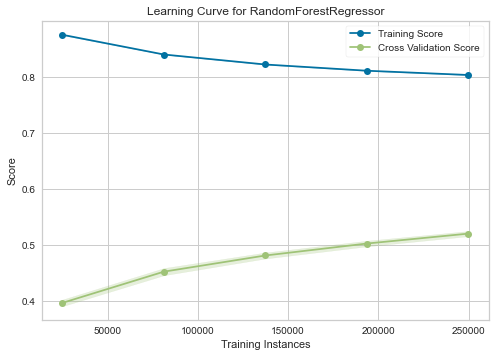

In [114]:
from yellowbrick.model_selection import LearningCurve
vis = LearningCurve(RandomForestRegressor(n_estimators=100, 
                                          random_state=42, n_jobs=-1), cv=10)
vis.fit(X_train, y_train)
vis.show()

## Otimização dos Hiperparâmetros

### Randomized Search

In [115]:
from sklearn.model_selection import RandomizedSearchCV

#### Random Forest Regression

In [116]:
# Hiperparâmetros atuais
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [117]:
random_grid = {'n_estimators': [20, 50, 100],
               'max_features': [4, 5, 6],
               'max_depth': [10, 20, 30, None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [118]:
# Tuning
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, 
                               random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 25.4min finished


{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 4,
 'max_depth': 20,
 'bootstrap': True}

In [119]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=20, max_features=4, min_samples_split=5)

In [120]:
# Avaliação da melhoria
rf_random_best = rf_random.best_estimator_
score_and_error(rf_random_best, X_train, y_train)

R^2: 0.7094624968539253 MAE: 171.27615566649996 RMSE: 237.20233142710575


#### Extra Trees Regression

In [121]:
# Hiperparâmetros atuais
model_etr.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [122]:
random_grid = {'n_estimators': [20, 50, 100],
               'max_features': [3, 5, 7],
               'max_depth': [10, 20, 30, None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [123]:
# Tuning
from sklearn.ensemble import ExtraTreesRegressor
etr = RandomForestRegressor()
etr_random = RandomizedSearchCV(estimator=etr, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, 
                               random_state=42, n_jobs=-1)
etr_random.fit(X_train, y_train)
etr_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 22.9min finished


{'n_estimators': 50,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 5,
 'max_depth': None,
 'bootstrap': True}

In [124]:
etr_random.best_estimator_

RandomForestRegressor(max_features=5, min_samples_split=10, n_estimators=50)

In [125]:
# Avaliação da melhoria
etr_random_best = etr_random.best_estimator_
score_and_error(etr_random_best, X_train, y_train)

R^2: 0.7149126290090879 MAE: 168.12211030014151 RMSE: 234.96698427451003


### Grid Search

In [126]:
from sklearn.model_selection import GridSearchCV

#### Random Forest Regression

In [127]:
search_grid = {'n_estimators': [100, 150],
               'max_features': [3, 4],
               'max_depth': [20, None],
               'min_samples_split': [5, 10],
               'min_samples_leaf': [1],
               'bootstrap': [True]}

In [128]:
# Tuning
rf = RandomForestRegressor()
rf_search = GridSearchCV(estimator=rf, param_grid=search_grid, cv=5, verbose=2, refit=True, n_jobs=-1)
rf_search.fit(X_train, y_train)
rf_search.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 21.1min finished


{'bootstrap': True,
 'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 150}

In [129]:
rf_search.best_estimator_

RandomForestRegressor(max_features=4, min_samples_split=10, n_estimators=150)

In [130]:
# Avaliação da melhoria
rf_search_best = rf_search.best_estimator_
score_and_error(rf_search_best, X_train, y_train)

R^2: 0.7134144592231211 MAE: 168.88759684595743 RMSE: 235.58356572579783


#### Extra Trees Regression

In [131]:
search_grid = {'n_estimators': [50, 100],
               'max_features': [4, 5],
               'max_depth': [20, 30, None],
               'min_samples_split': [10],
               'min_samples_leaf': [1],
               'bootstrap': [True]}

In [132]:
# Tuning
etr = ExtraTreesRegressor()
etr_search = GridSearchCV(estimator=etr, param_grid=search_grid, cv=5, verbose=2, refit=True, n_jobs=-1)
etr_search.fit(X_train, y_train)
etr_search.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.5min finished


{'bootstrap': True,
 'max_depth': None,
 'max_features': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [133]:
etr_search.best_estimator_

ExtraTreesRegressor(bootstrap=True, max_features=5, min_samples_split=10)

In [134]:
# Avaliação da melhoria
etr_search_best = etr_search.best_estimator_
score_and_error(etr_search_best, X_train, y_train)

R^2: 0.6681711392137388 MAE: 183.9417334936859 RMSE: 253.49823005298242


#### Melhores hiperparâmetros (após o Grid Search)

In [135]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
model_rf_best = RandomForestRegressor(bootstrap=True, max_depth=None, max_features=4, min_samples_leaf=1, 
                                      min_samples_split=10, n_estimators=150, 
                                      random_state=42, n_jobs=-1)
model_rf_best.fit(X_train, y_train)
score_and_error(model_rf_best, X_train, y_train)

R^2: 0.7132749199042424 MAE: 168.92467397331478 RMSE: 235.6409119018732


In [136]:
# Extra Trees Regressor
from sklearn.ensemble import ExtraTreesRegressor
model_etr_best = ExtraTreesRegressor(bootstrap=True, max_depth=None, max_features=5, min_samples_leaf=1, 
                                     min_samples_split=10, n_estimators=100,
                                     random_state=42, n_jobs=-1)
model_etr_best.fit(X_train, y_train)
score_and_error(model_etr_best, X_train, y_train)

R^2: 0.6687642033955474 MAE: 183.7849598010277 RMSE: 253.27159522291555


## Avaliação do modelo nos dados de teste

#### Random Forest Regression

In [137]:
score_and_error(model_rf_best, X_test[vars], y_test)

R^2: 0.5409373735818697 MAE: 214.2557183916884 RMSE: 298.60695175667263


#### Extra Trees Regression

In [138]:
score_and_error(model_etr_best, X_test[vars], y_test)

R^2: 0.5227462804201117 MAE: 220.46143266180894 RMSE: 304.4658632469712


## Visualização dos resultados

### Residuals Plot

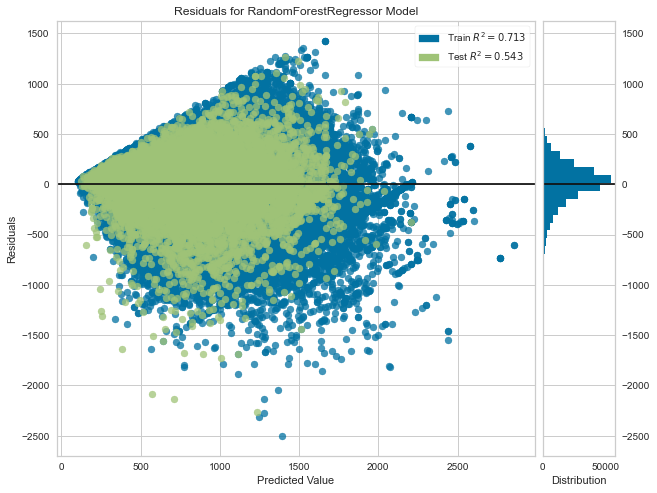

In [139]:
from yellowbrick.regressor import ResidualsPlot

fig, ax = plt.subplots(figsize=(10,8))
vis = ResidualsPlot(model_rf_best)
vis.fit(X_train, y_train)
vis.score(X_test[vars][:10000], y_test[:10000])
vis.show()

### Valores reais x valores da predição

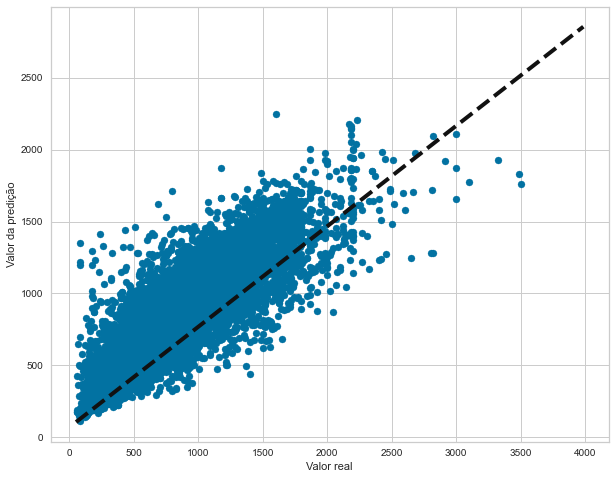

In [140]:
y_pred = model_rf_best.predict(X_train)
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(y_train[:10000], y_pred[:10000])
ax.plot([y_train.min(), y_train.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
ax.set_xlabel('Valor real')
ax.set_ylabel('Valor da predição')
plt.show()

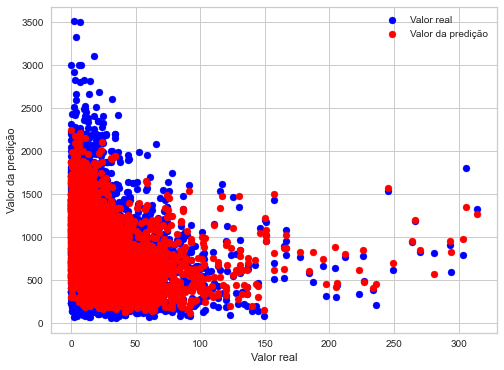

In [141]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X_train[:10000]['antecedencia'], y_train[:10000], color="blue", label="Valor real")
ax.scatter(X_train[:10000]['antecedencia'], y_pred[:10000], color="red", label="Valor da predição")
ax.set_xlabel('Valor real')
ax.set_ylabel('Valor da predição')
ax.legend()
plt.show()

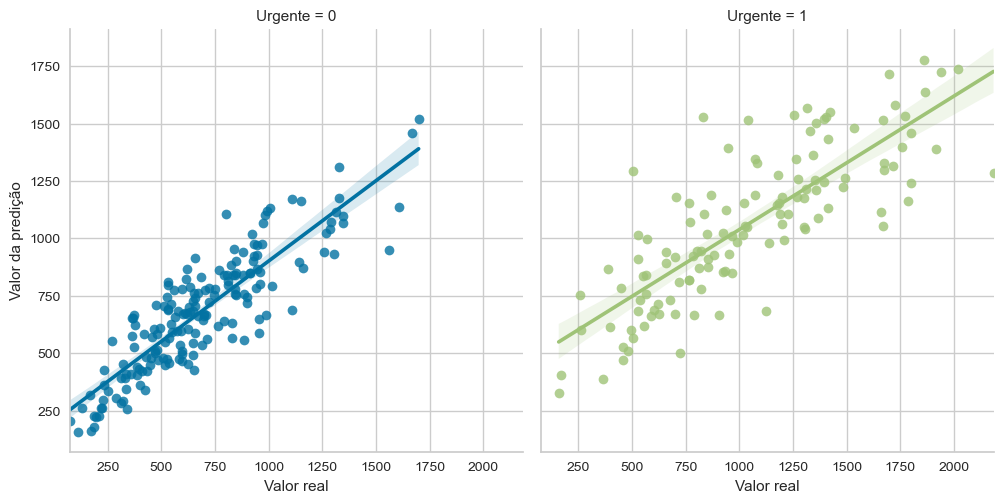

In [142]:
df_plot = pd.DataFrame({'Valor real': y_train, 'Valor da predição': y_pred, 'Urgente': X_train.viagem_urgente_sn})

# fig = plt.subplots(figsize=(8,6))
plt.rcParams.update({'figure.figsize':(10, 8), 'figure.dpi':100})
sns.lmplot(x='Valor real', y='Valor da predição', data=df_plot.sample(300), col='Urgente', hue='Urgente')

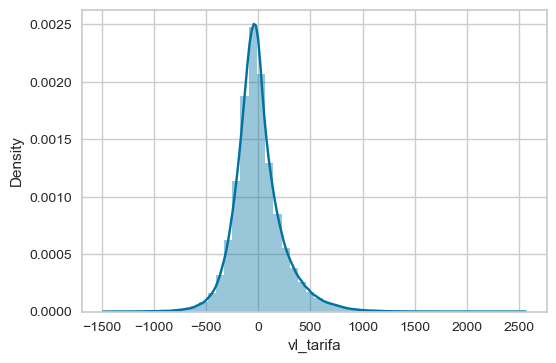

In [143]:
fig = plt.subplots(figsize=(6,4))
sns.distplot((y_train - y_pred), bins=50)

## Modelo Rede Neural (MLP) Multi-Layer Perceptron

In [144]:
trechos_prep = trechos_vars.copy()

####  Label encoding nas UFs destino

In [145]:
# Transformação da categoria UF destino em numérico
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
lbl_num = lbl.fit_transform(trechos_prep['uf_destino'])
trechos_prep.uf_destino = lbl_num

In [146]:
cols = ['uf_origem', 'cidade_origem', 'origem', 'cidade_destino', 'destino', 'trajeto']
trechos_prep.drop(cols, axis=1, inplace=True)
trechos_prep.columns

Index(['tipo_compra', 'uf_destino', 'viagem_urgente_sn', 'vl_tarifa',
       'latitude_origem', 'longitude_origem', 'latitude_destino',
       'longitude_destino', 'distancia', 'distancia_bin', 'trajeto_num',
       'antecedencia', 'antecede_log', 'mes_partida', 'mes_ferias',
       'dia_semana', 'fim_semana', 'segunda_ou_sexta', 'turno_viagem'],
      dtype='object')

#### Random Split

In [147]:
from sklearn.model_selection import train_test_split

X = trechos_prep.drop(columns=['vl_tarifa'])
y = trechos_prep['vl_tarifa']

# Separa conjunto de treino e teste
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

In [148]:
# Padronização dos dados
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

#### Rede neural MLP

In [149]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16421215117309308390,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3150367948
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3618510345606665134
 physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [150]:
# RN com 2 camadas ocultas com 64 neurônios + concat
def build_model():
    input = keras.layers.Input(shape=X_train.shape[1:])
    hidden1 = keras.layers.Dense(64, activation="relu")(input)
    hidden2 = keras.layers.Dense(64, activation="relu")(hidden1)
    concat = keras.layers.Concatenate()([input, hidden2])
    output = keras.layers.Dense(1)(concat)
    model = keras.models.Model(inputs=[input], outputs=[output])
    opt = keras.optimizers.Adam()
    model.compile(loss='mse', optimizer=opt, metrics=['mse','mae', 'mape'])
    return model

In [151]:
model = build_model()
epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=epochs, 
                    validation_data=(X_valid_scaled, y_valid), 
                    verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 194267 samples, validate on 83258 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 72s - loss: 155339.1017 - mean_squared_error: 155339.0781 - mean_absolute_error: 295.4599 - mean_absolute_percentage_error: 48.3275 - val_loss: 124607.9800 - val_mean_squared_error: 124607.8750 - val_mean_absolute_error: 270.4510 - val_mean_absolute_percentage_error: 45.9613
Epoch 2/20
 - 67s - loss: 122030.0488 - mean_squared_error: 122030.1719 - mean_absolute_error: 266.5173 - mean_absolute_percentage_error: 45.0774 - val_loss: 119944.9223 - val_mean_squared_error: 119944.8672 - val_mean_absolute_error: 263.8326 - val_mean_absolute_percentage_error: 44.6039
Epoch 3/20
 - 67s - loss: 118022.2600 - mean_squared_error: 118022.4219 - mean_absolute_error: 260.5343 - mean_absolute_percentage_error: 43.7321 - val_loss: 117034.1014 - val_mean_squared_error: 11703

In [152]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,val_loss,val_mean_squared_error,val_mean_absolute_error,val_mean_absolute_percentage_error,epoch
15,108119.728356,108119.718750,246.242279,40.474827,109298.350244,109298.320312,245.085739,39.120285,15
16,107752.552521,107752.484375,245.688950,40.319916,109039.353620,109039.320312,248.955627,41.494152,16
17,107384.759388,107384.812500,245.138931,40.202229,108713.309848,108713.359375,247.771271,41.352112,17
18,107033.094358,107033.210938,244.633606,40.094749,108323.161898,108323.320312,244.728607,39.321095,18
19,106688.289776,106688.171875,244.175751,39.963913,108080.506081,108080.617188,246.526627,40.604767,19


### Visualização

In [153]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [154]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

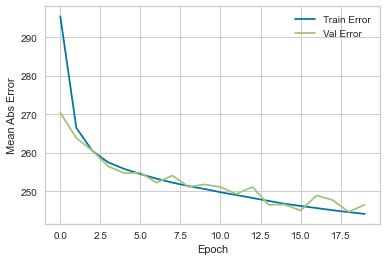

In [155]:
# Gráfico do MAE por épocas
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error')
plt.legend()
plt.show()

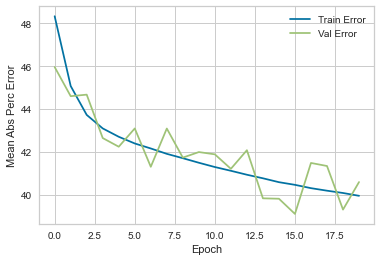

In [156]:
# Gráfico do MAPE por épocas
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Perc Error')
plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'], label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'], label = 'Val Error')
plt.legend()
plt.show()

### Avaliação do modelo nos dados de teste

In [157]:
loss, mse, mae, mape = model.evaluate(X_test_scaled, y_test, verbose=2)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))
print("Testing set Mean Abs Perc Error: {:5.2f}".format(mape))

 - 5s - loss: 108944.0078 - mean_squared_error: 108943.9922 - mean_absolute_error: 247.2562 - mean_absolute_percentage_error: 40.6203
Testing set Mean Abs Error: 247.26
Testing set Mean Abs Perc Error: 40.62
